<a href="https://www.kaggle.com/code/istiyaque6ty3/biased-superhero?scriptVersionId=115067337" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns #...
import math
myplate=sns.color_palette("Paired")
sns.set(style='white', palette=myplate)

import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
def bar_colorizer(n,*h1):
    colors=[]
    for i in range(n):
        if i+1 not in h1:
            colors.append('#ADD8E6')
        else:
            colors.append('#0D2241')
    return colors

print('^^Importing Important Stuff^^')

/kaggle/input/fivethirtyeight-comic-characters-dataset/marvel-wikia-data.csv
/kaggle/input/fivethirtyeight-comic-characters-dataset/README.md
/kaggle/input/fivethirtyeight-comic-characters-dataset/dc-wikia-data.csv
^^Importing Important Stuff^^


# Importing Stuff

In [2]:
marvel_path = "/kaggle/input/fivethirtyeight-comic-characters-dataset/marvel-wikia-data.csv"
dc_path = "/kaggle/input/fivethirtyeight-comic-characters-dataset/dc-wikia-data.csv"
marvel = pd.read_csv(marvel_path)
marvel.columns = marvel.columns.str.lower()
dc = pd.read_csv(dc_path)
dc.columns = dc.columns.str.lower()
dc['source'] = 'DC'
marvel['source'] = 'Marvel'
marvel['first_appearance_month'] = pd.to_datetime(marvel['first appearance'], format ="%b-%y").dt.strftime('%b')
dc['first_appearance_month'] = pd.to_datetime(dc['first appearance'], format ="%Y, %b", errors = 'coerce').dt.strftime('%b')
superh = pd.concat([marvel,dc])
superh=superh.reset_index()

# Explore, Treat

Let's view the first few rows and columns of our given dataset. The two datasets have been merged together into a single one for easier comparison.

In [3]:
superh.head()

,index,page_id,name,urlslug,id,align,eye,hair,sex,gsm,alive,appearances,first appearance,year,source,first_appearance_month
0,0,1678,Spider-Man (Peter Parker),\/Spider-Man_(Peter_Parker),Secret Identity,Good Characters,Hazel Eyes,Brown Hair,Male Characters,NaN,Living Characters,4043.0,Aug-62,1962.0,Marvel,Aug
1,1,7139,Captain America (Steven Rogers),\/Captain_America_(Steven_Rogers),Public Identity,Good Characters,Blue Eyes,White Hair,Male Characters,NaN,Living Characters,3360.0,Mar-41,1941.0,Marvel,Mar
2,2,64786,"Wolverine (James \""Logan\"" Howlett)",\/Wolverine_(James_%22Logan%22_Howlett),Public Identity,Neutral Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,3061.0,Oct-74,1974.0,Marvel,Oct
3,3,1868,"Iron Man (Anthony \""Tony\"" Stark)",\/Iron_Man_(Anthony_%22Tony%22_Stark),Public Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,2961.0,Mar-63,1963.0,Marvel,Mar
4,4,2460,Thor (Thor Odinson),\/Thor_(Thor_Odinson),No Dual Identity,Good Characters,Blue Eyes,Blond Hair,Male Characters,NaN,Living Characters,2258.0,Nov-50,1950.0,Marvel,Nov


Let's view some basic descriptive stats for the columns. For the current dataset only two numerical variables are available.

In [4]:
nume = ['appearances', 'year']
cate = ['id', 'align', 'eye', 'hair', 'sex', 'gsm',
       'alive', 'first_appearance_month', 'source']
superh.groupby(['source'])[nume].describe()

appearances                                                     \
             count       mean        std  min  25%  50%   75%     max   
source                                                                  
DC          6541.0  23.625134  87.378509  1.0  2.0  6.0  15.0  3093.0   
Marvel     15280.0  17.033377  96.372959  1.0  1.0  3.0   8.0  4043.0   

           year                                                          \
          count         mean        std     min     25%     50%     75%   
source                                                                    
DC       6827.0  1989.766662  16.824194  1935.0  1983.0  1992.0  2003.0   
Marvel  15561.0  1984.951803  19.663571  1939.0  1974.0  1990.0  2000.0   

                
           max  
source          
DC      2013.0  
Marvel  2013.0

Marvel has 2.5 times as many charcters as that of DC despite both of them starting at nearly the same time. As marvel has a larger pool of charcters, they appear fewer times compared to DC characters as seen for at least 75% of their charcters.

Oops!! Forgot to check for the null values

In [5]:
superh.isnull().sum()

index                         0
page_id                       0
name                          0
urlslug                       0
id                         5783
align                      3413
eye                       13395
hair                       6538
sex                         979
gsm                       23118
alive                         6
appearances                1451
first appearance            884
year                        884
source                        0
first_appearance_month     7187
dtype: int64

As most of these are categorical variables, there is not much that can be done. Only GSM could be treated by putting 'Not a minority' as the unavailable values. The name was split into hero name and their actual names.

In [6]:
superh.gsm = superh.gsm.fillna('Not a Minority')
nam = superh.name.str.split("(", n =1, expand= True)
superh['real_name'] = nam[1].str.replace(")", "")
superh['hero_name'] = nam[0]
superh = superh.dropna(subset=['first appearance', 'appearances', 'sex', 'align'])

After dropping multiple rows with null values, we now have the following number of missing values

In [7]:
superh.isnull().sum()

index                        0
page_id                      0
name                         0
urlslug                      0
id                        3666
align                        0
eye                       9580
hair                      4205
sex                          0
gsm                          0
alive                        2
appearances                  0
first appearance             0
year                         0
source                       0
first_appearance_month    5387
real_name                    7
hero_name                    0
dtype: int64

# Numeric Variables

<Figure size 1440x1440 with 0 Axes>

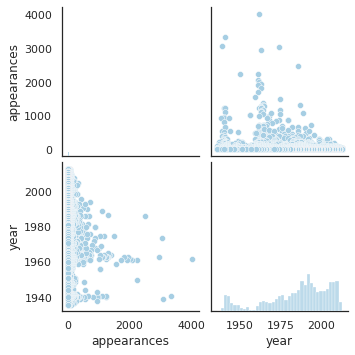

In [8]:
plt.figure(figsize= (20,20))
num_plot=sns.pairplot(superh[nume])
sns.despine()
plt.show()

# Categorical Variables

In [9]:
for col in cate:
    print('-'*40)
    print(f'The column name is: {col}')
    print(superh[col].value_counts())

----------------------------------------
The column name is: id
Secret Identity                  7023
Public Identity                  5548
No Dual Identity                 1239
Known to Authorities Identity      15
Identity Unknown                    9
Name: id, dtype: int64
----------------------------------------
The column name is: align
Bad Characters        8424
Good Characters       6664
Neutral Characters    2409
Reformed Criminals       3
Name: align, dtype: int64
----------------------------------------
The column name is: eye
Blue Eyes             2590
Brown Eyes            2270
Black Eyes             748
Green Eyes             708
Red Eyes               526
White Eyes             382
Yellow Eyes            253
Grey Eyes              114
Hazel Eyes              78
Photocellular Eyes      39
Purple Eyes             35
Variable Eyes           33
Orange Eyes             28
Gold Eyes               22
Pink Eyes               19
Violet Eyes             19
One Eye                 1

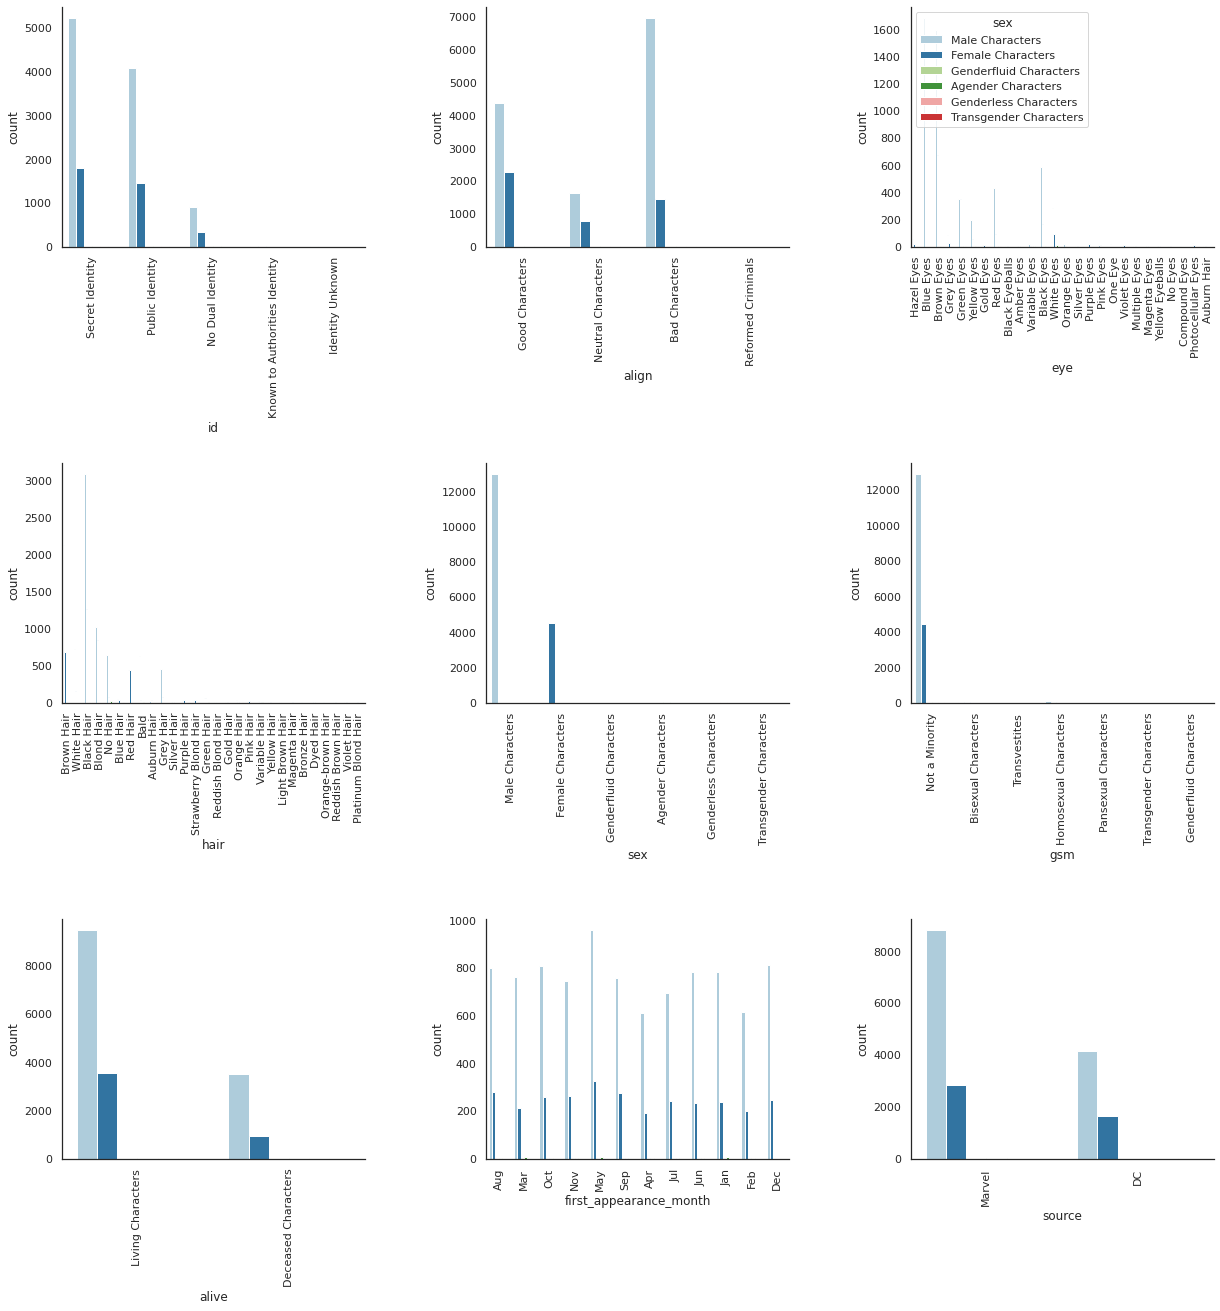

In [10]:
m=math.ceil(math.sqrt(len(cate)))
n=math.ceil(len(cate)/m)
fig, axes = plt.subplots(m,n,figsize=(20,20))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.9)

sns.despine()
for i in range(m):
    for j in range(n):
        sns.countplot(x= superh[cate[i*n+j]],
                    ax=axes[i,j], hue = superh['sex'])
        axes[i,j].tick_params(axis='x', labelrotation=90)
        if i!=0 or j !=2:
            axes[i,j].legend([],[], frameon=False)
        if i*n+j==len(cate)-1:
            break

Number plus Category

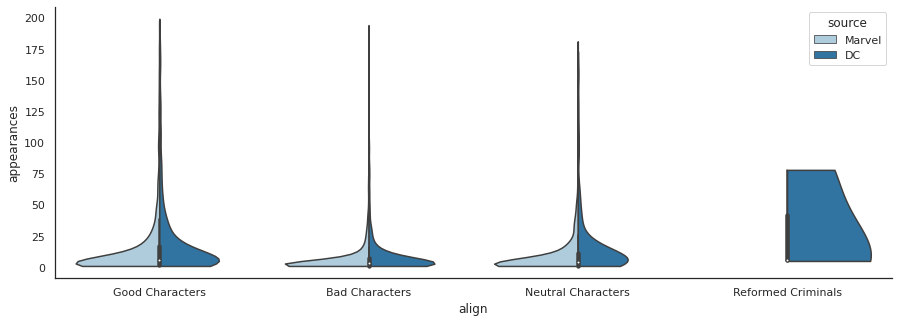

In [11]:
plt.figure(figsize= (15,5))
violin=sns.violinplot(x = 'align', y = "appearances", hue = 'source', data= superh[superh["appearances"]<200], cut = 0, split = True)
sns.despine()
plt.show()

# Male characters being portrayed as the bad characters.

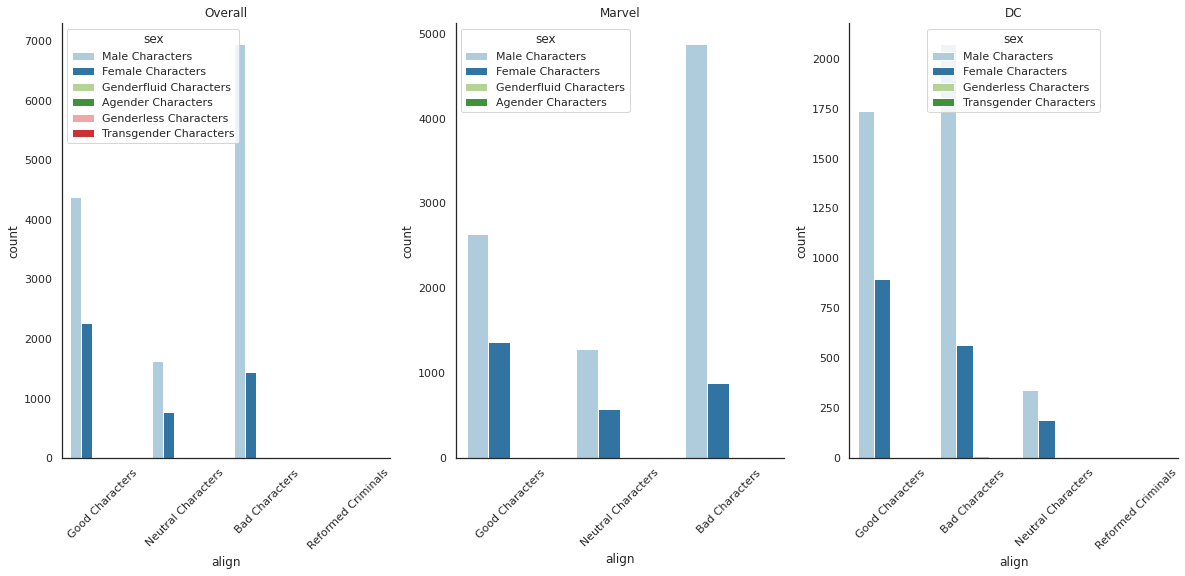

In [12]:
fig, axes = plt.subplots(1,3,figsize=(20,8))
violin=sns.countplot(x = 'align', hue = 'sex', data= superh, ax=axes[0])
violin=sns.countplot(x = 'align', hue = 'sex', data= superh[superh['source']=='Marvel'], ax=axes[1])
violin=sns.countplot(x = 'align', hue = 'sex', data= superh[superh['source']=='DC'], ax=axes[2])
axes[0].title.set_text('Overall')
axes[1].title.set_text('Marvel')
axes[2].title.set_text('DC')
for i in range(3):
    axes[i].tick_params(axis='x', labelrotation=45) 
sns.despine()
plt.show()

There are more bad male characters than are the good ones. Whereas, a larger portion of the female characters are good.

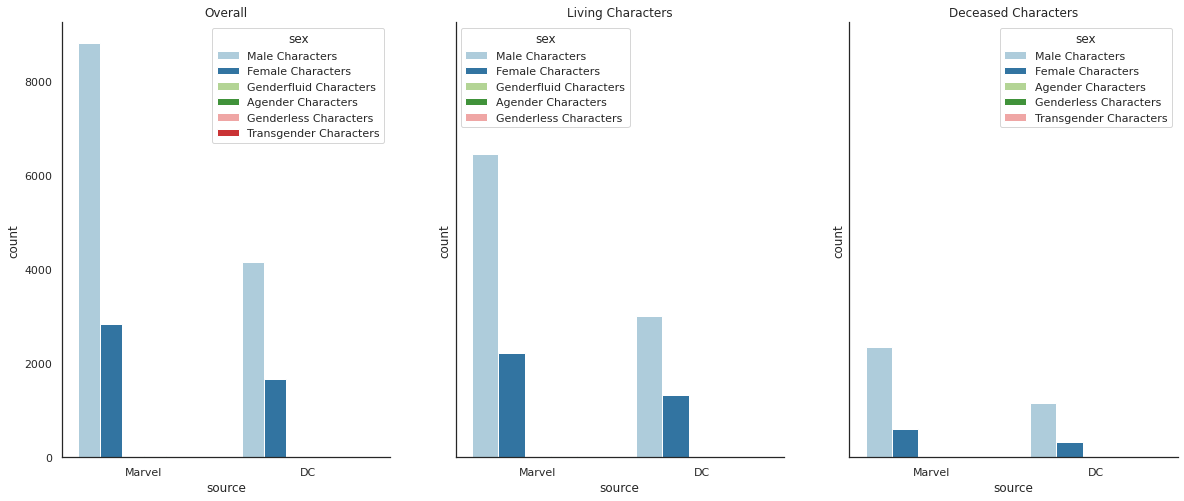

In [13]:
fig, axes = plt.subplots(1,3,figsize=(20,8), sharey = True)
violin=sns.countplot(x = 'source', hue = 'sex', data= superh, ax = axes [0])
violin=sns.countplot(x = 'source', hue = 'sex', data= superh[superh['alive']=='Living Characters'], ax = axes [1])
violin=sns.countplot(x = 'source', hue = 'sex', data= superh[superh['alive']=='Deceased Characters'], ax = axes [2])
axes[0].title.set_text('Overall')
axes[1].title.set_text('Living Characters')
axes[2].title.set_text('Deceased Characters')
sns.despine()
plt.show()

All the comics are more likely to create a male charcter. However, marvel is more biased in this regards. Just as more male characters are being created, more male characters are given deaths in the comics. 

In [14]:
countpivoted = superh[superh['appearances']>0].pivot_table(index="year", columns="sex", values ="appearances", aggfunc = "count")
sumpivoted = superh[superh['appearances']>0].pivot_table(index="year", columns="sex", values ="appearances", aggfunc = "sum")

# Compensating for Lack of Female Characters by Repetition

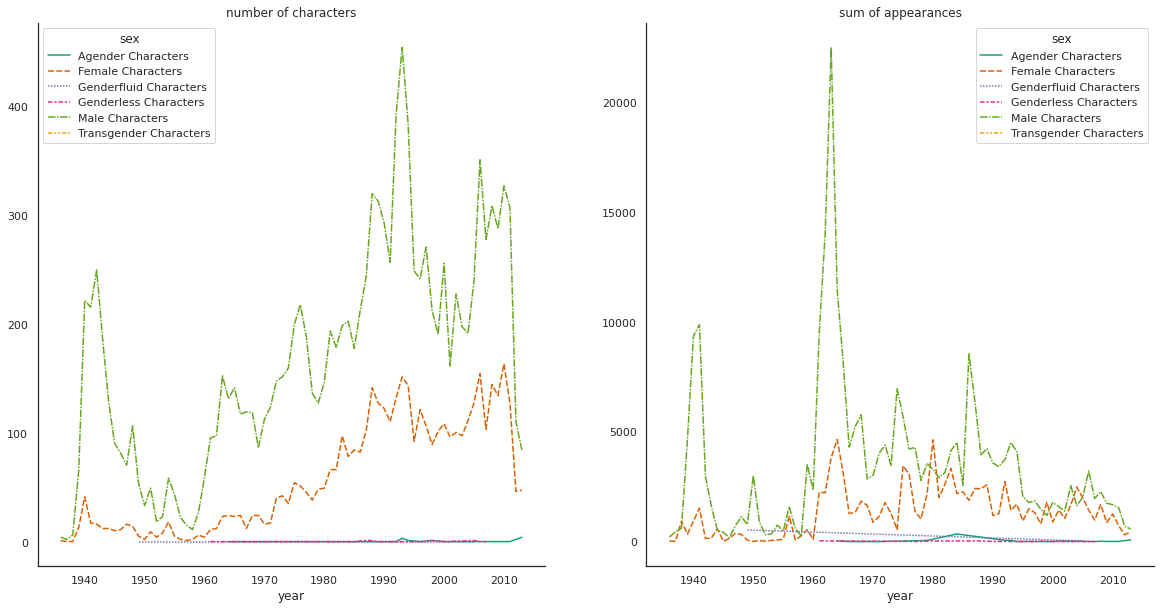

In [15]:
fig, axes = plt.subplots(1,2,figsize=(20,10))
sns.lineplot(data = countpivoted,palette = 'Dark2', err_style = None, ax = axes[0])
sns.lineplot(data = sumpivoted,palette = 'Dark2', err_style = None, ax = axes[1])
axes[0].title.set_text('number of characters')
axes[1].title.set_text('sum of appearances')
sns.despine()
plt.show()

Right Figure: Female characters were mainly introduced after 1960s. However, the number of characters only increased at a steady rate for female characters even when the number of male characters spiked on some years.

Left Figure: Despite creating a low number of female characters, they were made to appear nearly as many times as male characters in the last few decades. In some years, the female characters appeared more times compared to the male ones. This shows, how the companies do not invest in building new female characters but reuse the created few. 

# Important Note
I'm tired, so I'll be stopping here for now. Please let me know if there are other angles that I should explore and might provide other interesting insights. 